In [2]:
import sys
sys.path.append('..')
sys.path.append('../..')

import os
import numpy as np
import pandas as pd
import nitools as nt
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from SUITPy import flatmap
import PcmPy as pcm

import selective_recruitment.plotting as plotting
import selective_recruitment.globals as gl

import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as am
from statsmodels.stats.anova import AnovaRM  # perform F test
from selective_recruitment.scripts.script_roi_differences import norm_within_category,prep_roi_comparison, plot_roi_differences

# import warnings
# warnings.filterwarnings('ignore')


wkdir = 'A:\data\Cerebellum\CerebellumWorkingMemory\selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/srv/diedrichsen/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/Volumes/diedrichsen_data$/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'    
if not Path(wkdir).exists():
    wkdir = '/Users/jdiedrichsen/Data/wm_cerebellum/selective_recruit'

# Difference between ROIs in the Demand network

## Without anterior-posterior split

In [3]:
df_path = os.path.join(wkdir, "wm_ROI_NettekovenSym32_conn_reg.tsv")
DD = pd.read_csv(df_path, sep="\t")
DD, cond_map = prep_roi_comparison(DD)

c:\Users\lshah\OneDrive\Documents\Projects\selective_recruitment\notebooks\../..\selective_recruitment\scripts\script_roi_differences.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D['sn']=D['sn'].astype(int)
c:\Users\lshah\OneDrive\Documents\Projects\selective_recruitment\notebooks\../..\selective_recruitment\scripts\script_roi_differences.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D['cond_num']=D.phase*6+(1-D.recall)*3+D.load/2


c:\Users\lshah\OneDrive\Documents\Projects\selective_recruitment\notebooks\../..\selective_recruitment\scripts\script_roi_differences.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[value + '_norm'] = gb.transform(lambda x: (x - x.mean()))
C:\Users\lshah\AppData\Local\Temp\ipykernel_3812\3676602457.py:14: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.lineplot(data=D, x = 'cond_num', y = 'Y_norm', hue = 'roi_name',style='roi_name',
C:\Users\lshah\AppData\Local\Temp\ipykernel_3812\3676602457.py:14: UserWarning: The dashes list has more values (8) than needed (4), which may not be intended.
  ax = sns.lineplot(data=D, x = 'cond_num', y = 'Y_norm', hue = 'roi_name',style='roi_name',


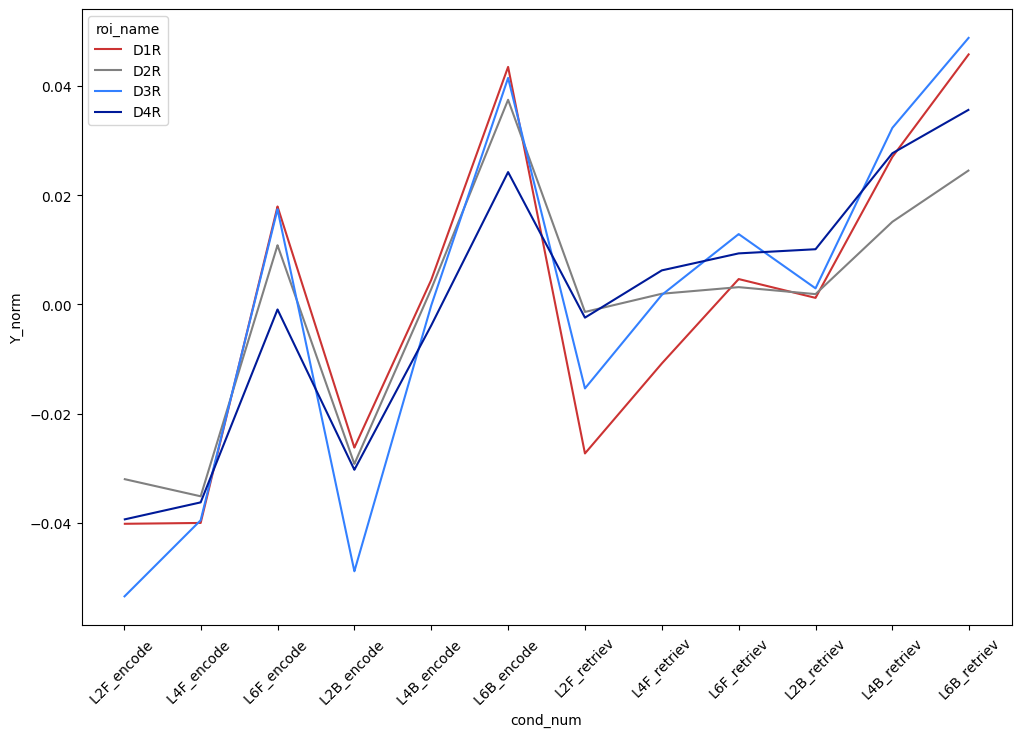

In [4]:
D = DD.loc[DD.side == "R"]
# D = DD.copy()
D = norm_within_category(D, category=['sn', "roi"], value='Y', norm='mean')
plt.figure(figsize=(12,8))
# Define styles and colors
d1 = (1,0)
d2 = (3,3)
red =(0.8,0.2,0.2)
gray = (0.5,0.5,0.5)
lb = (0.2,0.5,1.0)
db = (0.0,0.1,0.6)
pal = [red,gray,lb,db,red,gray,lb,db]

ax = sns.lineplot(data=D, x = 'cond_num', y = 'Y_norm', hue = 'roi_name',style='roi_name',
             palette=pal,
             dashes=[d1,d1,d1,d1,d2,d2,d2,d2],
             err_style=None)
# # Find mapping between cond_name and cond_num
ax.set_xticks(np.arange(12)+1)
l=ax.set_xticklabels(cond_map.cond_name.values, rotation=45)
# print(AnovaRM(data=D[D.cond_name != 'rest'], depvar='Y_norm',subject='sn', within=['load', 'phase', 'recall', "roi_name"], aggregate_func=np.mean).fit())
# DD = plotting.roi_difference(D, cond_map, depvar = "Y_norm", var = ["cond_name","roi_name"])


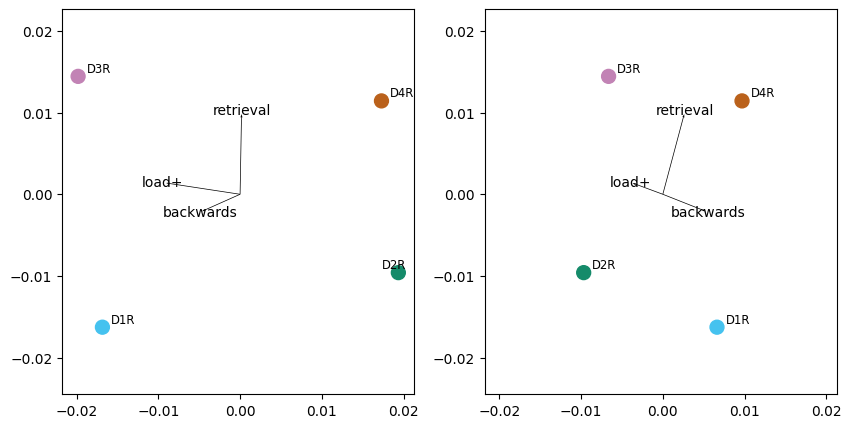

In [13]:
A = pd.pivot_table(data=D,index='roi_name',columns='cond_name',values='Y_norm',aggfunc=np.mean)
C=A.values
C=C/np.sqrt((C**2).sum(axis=1,keepdims=True))
B = C@C.T
K=3
W,V = plotting.calc_mds(A.values,K=K,center=True)
# phase, load, and recall
vs = np.array([[-1, 1,-1, 1,-1,1,-1,1,-1,1,-1,1],
                [-1,-1,-1,-1, 0,0, 0,0, 1,1, 1,1],
                [1,1, -1, -1, 1, 1, -1, -1,1,1, -1, -1]])
vs = vs/np.sqrt((vs**2).sum(axis=1,keepdims=True))
proj_vs = V @ vs.T

pal = ['#45C2EFFF', # light blue
       '#158B6AFF', # green
       '#C283B5FF', # purple
       '#BA611BFF', # dark orange
        ]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax1 = plotting.plot_mds(W[:,0],W[:,1],A.index,
                      colors=pal,
                      vectors=proj_vs[:2,:],
                      v_labels = ['retrieval','load+','backwards'])

plt.subplot(1,2,2, sharex=ax1)
ax2 = plotting.plot_mds(W[:,2],W[:,1],A.index,
                      colors=pal,
                      vectors=proj_vs[[2,1],:],
                      v_labels = ['retrieval','load+','backwards'])



plt.savefig('mds_roi.pdf',dpi=300)

# dd = pd.DataFrame(W,columns=['MDS1','MDS2','MDS3'],index=A.index)
# dd["roi_super"] = dd.index.str[0]
# dd["roi_idx"] = dd.index.str[1].astype(int)
# dd["roi_hemi"] = dd.index.str[2]
# # display(dd)

# vectors=proj_vs[:2,:]
# v_labels = ['retrieval','load+','backwards']

# pal = [red,gray,lb,db]
# # pal = [red,gray,lb,db,red,gray,lb,db]

# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plotting.plot_mds_sns(dd, x = 'MDS1', y='MDS2', 
#                       label = "roi_hemi", 
#                       hue = 'roi_idx', 
#                       style = 'roi_hemi',palette=pal,
#                       vectors = proj_vs[:2,:],
#                       v_labels = v_labels)
# plt.subplot(1,2,2)
# plotting.plot_mds_sns(dd, x = 'MDS3', y='MDS2', 
#                       label = "roi_hemi", 
#                       hue = 'roi_idx', palette=pal,
#                       style = 'roi_hemi',
#                       vectors = proj_vs[[2,1],:],
#                       v_labels = v_labels)

In [ ]:
# plotting.plot_mds3_plotly(W[:, 0], W[:, 1], W[:, 2], label = "NettekovenSym68c32", roi_super = "D", hue = "roi_idx", vectors = proj_vs)

## Parcellation divided into anterior and posterior

In [ ]:
df_path = os.path.join(wkdir, "ROI_NettekovenSym68c32AP_conn_reg.tsv")
D = pd.read_csv(df_path, sep="\t")
D, cond_map = prep_roi_comparison(D)

In [ ]:
D = norm_within_category(D, category=['roi_name','sn'], value='Y', norm='mean')
D = D.loc[D.roi != 0]
D = D.loc[D.cond_name != "rest"]
D["AP"] = D["roi_name"].str[4]
plt.figure(figsize=(12,8))
# # Define styles and colors
# # pal = [
# #     (0, 0, 0),             # Black
# #     (0.86, 0.371, 0.339),  # Red
# #     (0.439, 0.678, 0.278), # Green
# #     (0.0, 0.447, 0.698),   # Blue
# #     (0.882, 0.549, 0.152), # Orange
# #     (0.529, 0.235, 0.447), # Purple
# #     (1.0, 0.882, 0.098),   # Yellow
# #     (0.333, 0.659, 0.408), # Teal
# #     (0.0, 0.431, 0.443),   # Cyan
# #     (0.878, 0.525, 0.541), # Pink
# #     (0.82, 0.725, 0.004),  # Gold
# #     (0.337, 0.706, 0.914), # Sky Blue
# #     (0.58, 0.403, 0.741),  # Lavender
# #     (1.0, 0.647, 0.0),     # Orange Yellow
# #     (0.922, 0.435, 0.71),  # Rose
# #     (0.616, 0.733, 0.333)  # Chartreuse
# # ]

# pal = [
#     (0, 0, 0),             # Black D1LA
#     (0, 0, 0, 0.3),        # Black D1LA
#     (0.86, 0.371, 0.339),  # Red D1RA
#     (0.86, 0.371, 0.339, 0.3),  # Red D1RP
#     (0.58, 0.403, 0.741),  # Lavender D2LA
#     (0.58, 0.403, 0.741, 0.3),  # Lavender D2LP
#     (0.0, 0.447, 0.698),   # Blue D2RA
#     (0.0, 0.447, 0.698, 0.3),   # Blue D2RA
#     (0.882, 0.549, 0.152), # Orange D3LA
#     (0.882, 0.549, 0.152, 0.3), # Orange D3LP
#     (0.529, 0.235, 0.447), # Purple D3RA
#     (0.529, 0.235, 0.447, 0.3), # Purple D3RP
#     (0.616, 0.733, 0.333),  # Chartreuse D4LA
#     (0.616, 0.733, 0.333, 0.3),  # Chartreuse D4LP
#     (0.333, 0.659, 0.408), # Teal D4RA
#     (0.333, 0.659, 0.408, 0.3), # Teal   D4RP 
# ]


# DD = plot_roi_differences(D, cond_map, depvar = "Y_norm", var = ["cond_name", "AP", "side"])


In [ ]:
A = pd.pivot_table(data=D,index='roi_name',columns='cond_name',values='Y_norm',aggfunc=np.mean)
C=A.values
C=C/np.sqrt((C**2).sum(axis=1,keepdims=True))
B = C@C.T

K=3
W,V = plotting.calc_mds(A.values,K=K,center=True)
# phase, load, and recall
vs = np.array([[-1, 1,-1, 1,-1,1,-1,1,-1,1,-1,1],
                [-1,-1,-1,-1, 0,0, 0,0, 1,1, 1,1],
                [1,1, -1, -1, 1, 1, -1, -1,1,1, -1, -1]])
vs = vs/np.sqrt((vs**2).sum(axis=1,keepdims=True))
proj_vs = V @ vs.T

# pal = [redA,redA,redP,redP,grayA,grayA,grayP,grayP,lbA,lbA,lbP,lbP,dbA,dbA,dbP,dbP]
# pal = colors_rgba
# pal = colorblind_friendly_colors

# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plotting.plot_mds(W[:,0],W[:,1],A.index,
#                       colors=pal,
#                       vectors=proj_vs[:2,:],
#                       v_labels = ['retrieval','load+','backwards'])
# plt.subplot(1,2,2)
# plotting.plot_mds(W[:,2],W[:,1],A.index,
#                       colors=pal,
#                       vectors=proj_vs[[2,1],:],
#                       v_labels = ['retrieval','load+','backwards'])
dd = pd.DataFrame(W,columns=['MDS1','MDS2','MDS3'],index=A.index)
dd["roi_super"] = dd.index.str[0]
dd["roi_idx"] = dd.index.str[1].astype(int)
dd["roi_ap"] = dd.index.str[-1]
dd["roi_hemi"] = dd.index.str[2]
# display(dd)

vectors=proj_vs[:2,:]
v_labels = ['retrieval','load+','backwards']
pal = [red,gray,lb,db]


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plotting.plot_mds_sns(dd, x = 'MDS1', y='MDS2', 
                      label = "roi_hemi", 
                      hue = 'roi_idx', 
                      style = 'roi_ap',palette=pal,
                      vectors = proj_vs[:2,:],
                      v_labels = v_labels)
plt.subplot(1,2,2)
plotting.plot_mds_sns(dd, x = 'MDS3', y='MDS2', 
                      label = "roi_hemi", 
                      hue = 'roi_idx', 
                      style = 'roi_ap',palette=pal,
                      vectors = proj_vs[[2,1],:],
                      v_labels = v_labels)

In [ ]:
# pal = [
#     (0, 0, 0),             # Black D1LA
#     (0, 0, 0, 0.3),        # Black D1LA
#     (0.86, 0.371, 0.339),  # Red D1RA
#     (0.86, 0.371, 0.339, 0.3),  # Red D1RP
#     (0.58, 0.403, 0.741),  # Lavender D2LA
#     (0.58, 0.403, 0.741, 0.3),  # Lavender D2LP
#     (0.0, 0.447, 0.698),   # Blue D2RA
#     (0.0, 0.447, 0.698, 0.3),   # Blue D2RA
#     (0.882, 0.549, 0.152), # Orange D3LA
#     (0.882, 0.549, 0.152, 0.3), # Orange D3LP
#     (0.529, 0.235, 0.447), # Purple D3RA
#     (0.529, 0.235, 0.447, 0.3), # Purple D3RP
#     (0.616, 0.733, 0.333),  # Chartreuse D4LA
#     (0.616, 0.733, 0.333, 0.3),  # Chartreuse D4LP
#     (0.333, 0.659, 0.408), # Teal D4RA
#     (0.333, 0.659, 0.408, 0.3), # Teal   D4RP 
# ]
plotting.plot_mds3(W[:,0],W[:,1], W[:,1], 
                   A.index, 
                   colors=pal,
                   text_size = 'small', 
                   text_weight = 'regular',
                   vectors = proj_vs,
                   v_labels = ['retrieval','load+','backwards'])

In [ ]:
# plotting.plot_mds3_new(W[:, 0], W[:, 1], W[:, 2], label = "NettekovenSym68c32AP", roi_super = "D", hue = "roi_idx", vectors = proj_vs)